# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score
from sklearn.datasets import make_blobs
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load the House Price Dataset

In [ ]:
house_data = pd.read_csv('~/Downloads/house-price-data.csv')
house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   1201 non-null   float64
 1   LotArea       1460 non-null   int64  
 2   GarageArea    1460 non-null   int64  
 3   YearBuilt     1460 non-null   int64  
 4   YearRemodAdd  1460 non-null   int64  
 5   BsmtCond      1423 non-null   object 
 6   Fence         281 non-null    object 
 7   RoofStyle     1460 non-null   object 
 8   Heating       1460 non-null   object 
 9   SalePrice     1460 non-null   int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 114.2+ KB


In [ ]:
house_data.head()

,LotFrontage,LotArea,GarageArea,YearBuilt,YearRemodAdd,BsmtCond,Fence,RoofStyle,Heating,SalePrice
0,65.0,8450,548,2003,2003,TA,NaN,Gable,GasA,208500
1,80.0,9600,460,1976,1976,TA,NaN,Gable,GasA,181500
2,68.0,11250,608,2001,2002,TA,NaN,Gable,GasA,223500
3,60.0,9550,642,1915,1970,Gd,NaN,Gable,GasA,140000
4,84.0,14260,836,2000,2000,TA,NaN,Gable,GasA,250000


In [ ]:
house_data.shape

(1460, 10)

# Check for Missing Values

In [ ]:
# let's identify the categorical variables

categorical = [var for var in house_data.columns if house_data[var].dtype == 'O']

# number of categorical variables
len(categorical)

4

In [ ]:
categorical

['BsmtCond', 'Fence', 'RoofStyle', 'Heating']

In [ ]:
# which categorical variables have missing data?
print(house_data[categorical].isnull().sum())

BsmtCond     0
Fence        0
RoofStyle    0
Heating      0
dtype: int64


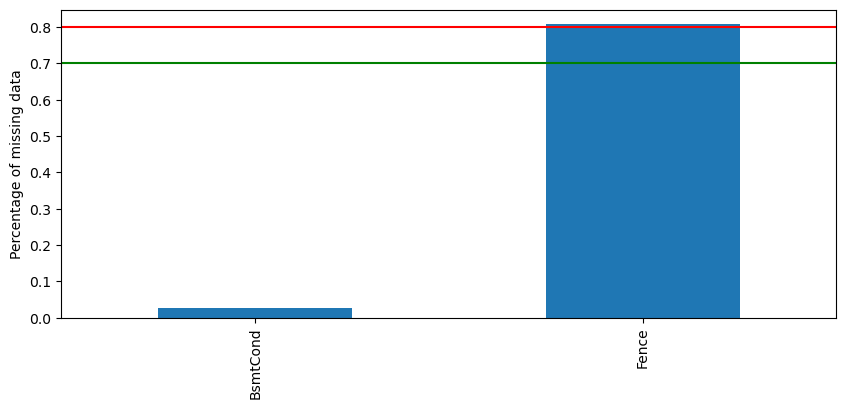

In [ ]:
# capture categorical variables with NA in a dictionary
null_cat = {var: house_data[var].isnull().mean() for var in categorical if house_data[var].isnull().mean()>0}

# plot
pd.Series(null_cat).sort_values().plot.bar(figsize=(10,4))
plt.ylabel('Percentage of missing data')
plt.axhline(y = 0.80, color = 'r', linestyle = '-')
plt.axhline(y = 0.70, color = 'g', linestyle = '-')

plt.show()

In [ ]:
# let's identify the numeric variables
numerical = house_data.select_dtypes(include=['number']).columns.tolist()
len(numerical)

6

In [ ]:
# which numerical variables have missing data?
house_data[numerical].isnull().sum()

LotFrontage     0
LotArea         0
GarageArea      0
YearBuilt       0
YearRemodAdd    0
SalePrice       0
dtype: int64

# Impute Missing Values

In [ ]:
# using the mean
lf_mean = house_data['LotFrontage'].mean()
house_data.fillna({'LotFrontage': lf_mean}, inplace=True)

# using the median
# lf_median = house_data['LotFrontage'].median()
# house_data.fillna({'LotFrontage': lf_median}, inplace=True)

# using the mode
bc_mode = house_data['BsmtCond'].mode()[0]
house_data.fillna({'BsmtCond': bc_mode}, inplace=True)


# Drop this column? it has too many missing values
#house_data.drop('Fence', axis = 1, inplace = True)
fence_mode = house_data['Fence'].mode()[0]
house_data.fillna({'Fence': fence_mode}, inplace=True)

# One-hot Encoding

In [ ]:
one_hot_encoded_df = pd.get_dummies(house_data, columns=categorical, drop_first=False)
print(one_hot_encoded_df.columns)

Index(['LotFrontage', 'LotArea', 'GarageArea', 'YearBuilt', 'YearRemodAdd',
       'SalePrice', 'BsmtCond_Fa', 'BsmtCond_Gd', 'BsmtCond_Po', 'BsmtCond_TA',
       'Fence_GdPrv', 'Fence_GdWo', 'Fence_MnPrv', 'Fence_MnWw',
       'RoofStyle_Flat', 'RoofStyle_Gable', 'RoofStyle_Gambrel',
       'RoofStyle_Hip', 'RoofStyle_Mansard', 'RoofStyle_Shed', 'Heating_Floor',
       'Heating_GasA', 'Heating_GasW', 'Heating_Grav', 'Heating_OthW',
       'Heating_Wall'],
      dtype='object')


In [ ]:
house_data['Fence'].unique()

array(['MnPrv', 'GdWo', 'GdPrv', 'MnWw'], dtype=object)

In [ ]:
one_hot_encoded_df

,LotFrontage,LotArea,GarageArea,YearBuilt,YearRemodAdd,SalePrice,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,...,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall
0,65.0,8450,548,2003,2003,208500,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
1,80.0,9600,460,1976,1976,181500,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
2,68.0,11250,608,2001,2002,223500,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
3,60.0,9550,642,1915,1970,140000,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False
4,84.0,14260,836,2000,2000,250000,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,62.0,7917,460,1999,2000,175000,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
1456,85.0,13175,500,1978,1988,210000,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
1457,66.0,9042,252,1941,2006,266500,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False
1458,68.0,9717,240,1950,1996,142125,False,False,False,True,...,False,True,False,False,False,True,False,False,False,False


# Label Encoding

In [ ]:
# Use label encoding to encode your target variable (not the features)
label_encoder = LabelEncoder()
house_data['BsmtCond_Encoded'] = label_encoder.fit_transform(house_data['BsmtCond'])
print(house_data)

      LotFrontage  LotArea  GarageArea  YearBuilt  YearRemodAdd BsmtCond  \
0            65.0     8450         548       2003          2003       TA   
1            80.0     9600         460       1976          1976       TA   
2            68.0    11250         608       2001          2002       TA   
3            60.0     9550         642       1915          1970       Gd   
4            84.0    14260         836       2000          2000       TA   
...           ...      ...         ...        ...           ...      ...   
1455         62.0     7917         460       1999          2000       TA   
1456         85.0    13175         500       1978          1988       TA   
1457         66.0     9042         252       1941          2006       Gd   
1458         68.0     9717         240       1950          1996       TA   
1459         75.0     9937         276       1965          1965       TA   

      Fence RoofStyle Heating  SalePrice  BsmtCond_Encoded  
0     MnPrv     Gable    G

In [ ]:
house_data

,LotFrontage,LotArea,GarageArea,YearBuilt,YearRemodAdd,BsmtCond,Fence,RoofStyle,Heating,SalePrice,BsmtCond_Encoded
0,65.0,8450,548,2003,2003,TA,MnPrv,Gable,GasA,208500,3
1,80.0,9600,460,1976,1976,TA,MnPrv,Gable,GasA,181500,3
2,68.0,11250,608,2001,2002,TA,MnPrv,Gable,GasA,223500,3
3,60.0,9550,642,1915,1970,Gd,MnPrv,Gable,GasA,140000,1
4,84.0,14260,836,2000,2000,TA,MnPrv,Gable,GasA,250000,3
...,...,...,...,...,...,...,...,...,...,...,...
1455,62.0,7917,460,1999,2000,TA,MnPrv,Gable,GasA,175000,3
1456,85.0,13175,500,1978,1988,TA,MnPrv,Gable,GasA,210000,3
1457,66.0,9042,252,1941,2006,Gd,GdPrv,Gable,GasA,266500,1
1458,68.0,9717,240,1950,1996,TA,MnPrv,Hip,GasA,142125,3


# Ordinal Encoding

In [ ]:
#house_data['BsmtCond'].unique()

{
    "Po": 0,
    "TA": 1,
    "Fa": 2,
    "Gd": 3
}

array(['TA', 'Gd', 'Fa', 'Po'], dtype=object)

In [ ]:
house_data['BsmtCond']

0       TA
1       TA
2       TA
3       Gd
4       TA
        ..
1455    TA
1456    TA
1457    Gd
1458    TA
1459    TA
Name: BsmtCond, Length: 1460, dtype: object

In [ ]:
# Use label encoding to encode your target variable (not the features)
ordinal_encoder = OrdinalEncoder(categories = [['Po', 'TA', 'Fa', 'Gd']])
ordinal_encoder.fit_transform(pd.DataFrame(house_data['BsmtCond']))
#print(house_data)

array([[1.],
       [1.],
       [1.],
       ...,
       [3.],
       [1.],
       [1.]])

In [ ]:
one_hot_encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   LotFrontage        1460 non-null   float64
 1   LotArea            1460 non-null   int64  
 2   GarageArea         1460 non-null   int64  
 3   YearBuilt          1460 non-null   int64  
 4   YearRemodAdd       1460 non-null   int64  
 5   SalePrice          1460 non-null   int64  
 6   BsmtCond_Fa        1460 non-null   bool   
 7   BsmtCond_Gd        1460 non-null   bool   
 8   BsmtCond_Po        1460 non-null   bool   
 9   BsmtCond_TA        1460 non-null   bool   
 10  Fence_GdPrv        1460 non-null   bool   
 11  Fence_GdWo         1460 non-null   bool   
 12  Fence_MnPrv        1460 non-null   bool   
 13  Fence_MnWw         1460 non-null   bool   
 14  RoofStyle_Flat     1460 non-null   bool   
 15  RoofStyle_Gable    1460 non-null   bool   
 16  RoofStyle_Gambrel  1460 

# Min-Max Scaling
Only appies to numeric columns

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(one_hot_encoded_df)
print(scaled_data)

[[0.15068493 0.0334198  0.3864598  ... 0.         0.         0.        ]
 [0.20205479 0.03879502 0.32440056 ... 0.         0.         0.        ]
 [0.1609589  0.04650728 0.42877292 ... 0.         0.         0.        ]
 ...
 [0.15410959 0.03618687 0.17771509 ... 0.         0.         0.        ]
 [0.1609589  0.03934189 0.16925247 ... 0.         0.         0.        ]
 [0.18493151 0.04037019 0.19464034 ... 0.         0.         0.        ]]


# Standard Scaler
Only appies to numeric columns

In [ ]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
scaled_data = std_scaler.fit_transform(one_hot_encoded_df)
print(scaled_data)

[[-0.22937175 -0.20714171  0.35100032 ... -0.06940907 -0.03703704
  -0.05241424]
 [ 0.4519361  -0.09188637 -0.06073101 ... -0.06940907 -0.03703704
  -0.05241424]
 [-0.09311018  0.07347998  0.63172623 ... -0.06940907 -0.03703704
  -0.05241424]
 ...
 [-0.18395123 -0.14781027 -1.03391416 ... -0.06940907 -0.03703704
  -0.05241424]
 [-0.09311018 -0.08016039 -1.09005935 ... -0.06940907 -0.03703704
  -0.05241424]
 [ 0.22483348 -0.05811155 -0.9216238  ... -0.06940907 -0.03703704
  -0.05241424]]


# Creating New Feature

In [ ]:
# Drop YearRemodAdd and YearBuilt after this?
house_data['Years_Elapsed'] = house_data['YearRemodAdd'] - house_data['YearBuilt']
house_data['Years_Elapsed']

# Split Data intro Train/Test Splits

In [ ]:
one_hot_encoded_df.columns

Index(['LotFrontage', 'LotArea', 'GarageArea', 'YearBuilt', 'YearRemodAdd',
       'SalePrice', 'BsmtCond_Fa', 'BsmtCond_Gd', 'BsmtCond_Po', 'BsmtCond_TA',
       'Fence_GdPrv', 'Fence_GdWo', 'Fence_MnPrv', 'Fence_MnWw',
       'RoofStyle_Flat', 'RoofStyle_Gable', 'RoofStyle_Gambrel',
       'RoofStyle_Hip', 'RoofStyle_Mansard', 'RoofStyle_Shed', 'Heating_Floor',
       'Heating_GasA', 'Heating_GasW', 'Heating_Grav', 'Heating_OthW',
       'Heating_Wall'],
      dtype='object')

In [ ]:
y = one_hot_encoded_df['SalePrice']
# drop the target variable
X = one_hot_encoded_df.drop('SalePrice', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)


# Linear Regression

In [ ]:
# Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions
y_pred = lr.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
print(f"Linear Regression Mean Squared Error: {mse:.2f}")

Linear Regression Mean Squared Error: 3349645410.95


# Logistic Regression

In [ ]:
diabetes_df = pd.read_csv('/Users/admin/Downloads/diabetes.csv')
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load dataset
diabetes_df = pd.read_csv('/Users/admin/Downloads/diabetes.csv')

y = diabetes_df['Outcome']
X = diabetes_df.drop('Outcome', axis = 1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Logistic Regression
log_reg = LogisticRegression(max_iter=200)
log_reg.fit(X_train, y_train)

# Predictions
y_pred = log_reg.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy:.2f}")

Logistic Regression Accuracy: 0.82


# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

# uncomment this line to get different splits
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Predictions
y_pred = dt.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"Decision Tree Accuracy: {accuracy:.2f}")


Decision Tree Accuracy: 0.71


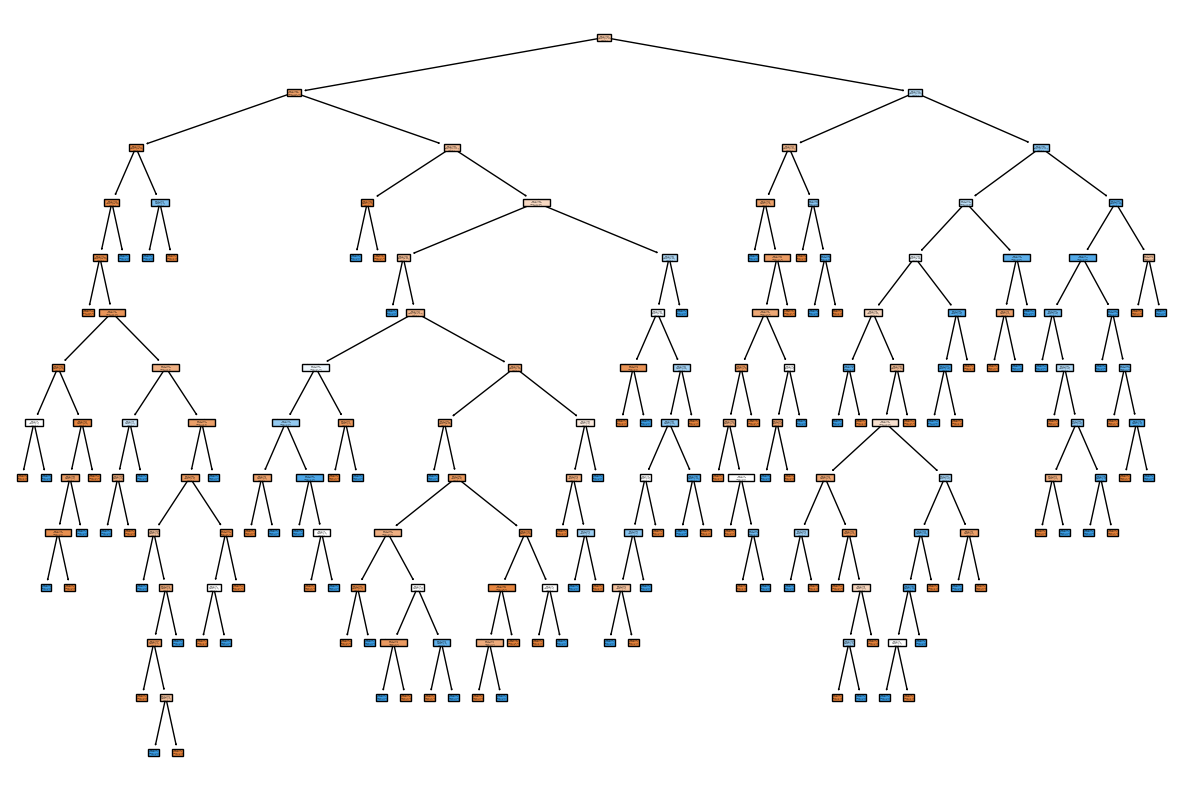

In [ ]:
# Plot the resulting Decision Tree
from sklearn.tree import plot_tree

# Plot the decision tree
plt.figure(figsize=(15, 10))
plot_tree(dt, feature_names=list(X.columns), class_names=y.astype("string").unique(), filled=True)
plt.show()

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.2f}")


Random Forest Accuracy: 0.77


# K-Nearest Neighbors (KNN)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predictions
y_pred = knn.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"KNN Accuracy: {accuracy:.2f}")

KNN Accuracy: 0.74


# K-Fold Cross-Validation

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris

# Load dataset
diabetes_df = pd.read_csv('/Users/admin/Downloads/diabetes.csv')

y = diabetes_df['Outcome']
X = diabetes_df.drop('Outcome', axis = 1)

# Initialize the model
model = RandomForestClassifier()

# Perform K-Fold Cross-Validation
scores = cross_val_score(model, X, y, cv=10)
print(f"Cross-Validation Scores: {scores}")
print(f"Mean CV Score: {scores.mean()}")


Cross-Validation Scores: [0.68831169 0.77922078 0.72727273 0.71428571 0.74025974 0.81818182
 0.83116883 0.84415584 0.65789474 0.80263158]
Mean CV Score: 0.7603383458646616


In [ ]:
X

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33
...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63
764,2,122,70,27,0,36.8,0.340,27
765,5,121,72,23,112,26.2,0.245,30
766,1,126,60,0,0,30.1,0.349,47


# Generate Sample Data?

In [ ]:
# Generate synthetic dataset with 3 clusters
#X, y_true = make_blobs(n_samples=300, centers=3, cluster_std=1.0, random_state=42)

# for the X data, only use two features for visualisation purposes
X = X.values
X = X[:, [1,5]]

# K-Means Clustering

K-Means Silhouette Score: 0.53
K-Means Davies-Bouldin Index: 0.66
K-Means Calinski-Harabasz Index: 1178.55


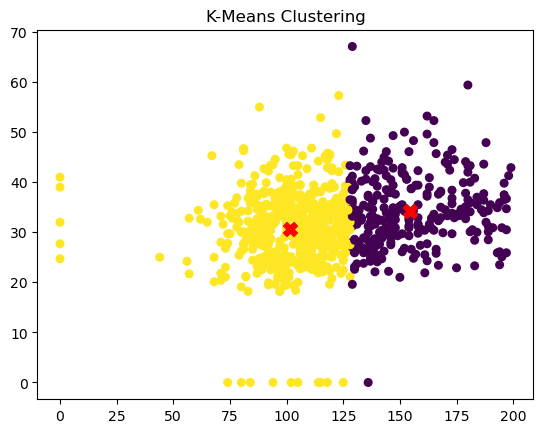

In [ ]:
# Apply K-Means
kmeans = KMeans(n_clusters = 2, random_state = 7367364)
y_kmeans = kmeans.fit_predict(X)

# Evaluate K-Means
silhouette_avg = silhouette_score(X, y_kmeans)
davies_bouldin = davies_bouldin_score(X, y_kmeans)
calinski_harabasz = calinski_harabasz_score(X, y_kmeans)

print(f"K-Means Silhouette Score: {silhouette_avg:.2f}")
print(f"K-Means Davies-Bouldin Index: {davies_bouldin:.2f}")
print(f"K-Means Calinski-Harabasz Index: {calinski_harabasz:.2f}")

# Plot K-Means Clustering
plt.scatter(X[:, 0], X[:, 1], c = y_kmeans, cmap='viridis', s=30)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=100)
plt.title('K-Means Clustering')
plt.show()


In [ ]:
kmeans.cluster_centers_

array([[154.63571429,  34.32142857],
       [101.53483607,  30.65635246]])

# Hierarchical Clustering

Hierarchical Silhouette Score: 0.42
Hierarchical Davies-Bouldin Index: 0.72
Hierarchical Calinski-Harabasz Index: 1046.65


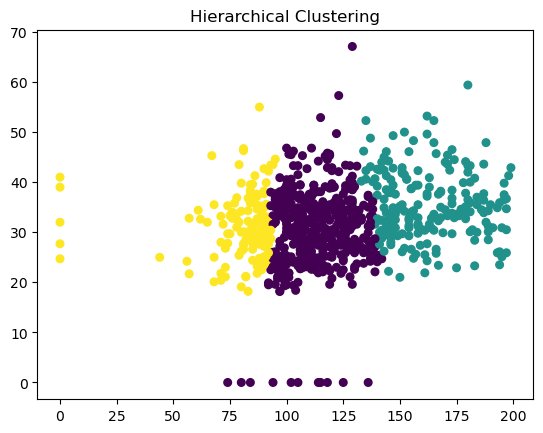

In [ ]:
# Apply Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=3, linkage='ward')
y_hierarchical = hierarchical.fit_predict(X)

# Evaluate Hierarchical Clustering
silhouette_avg_hc = silhouette_score(X, y_hierarchical)
davies_bouldin_hc = davies_bouldin_score(X, y_hierarchical)
calinski_harabasz_hc = calinski_harabasz_score(X, y_hierarchical)

print(f"Hierarchical Silhouette Score: {silhouette_avg_hc:.2f}")
print(f"Hierarchical Davies-Bouldin Index: {davies_bouldin_hc:.2f}")
print(f"Hierarchical Calinski-Harabasz Index: {calinski_harabasz_hc:.2f}")

# Plot Hierarchical Clustering
plt.scatter(X[:, 0], X[:, 1], c = y_hierarchical, cmap='viridis', s=30)
plt.title('Hierarchical Clustering')
plt.show()


## Dendrogram for Hierarchical Clustering

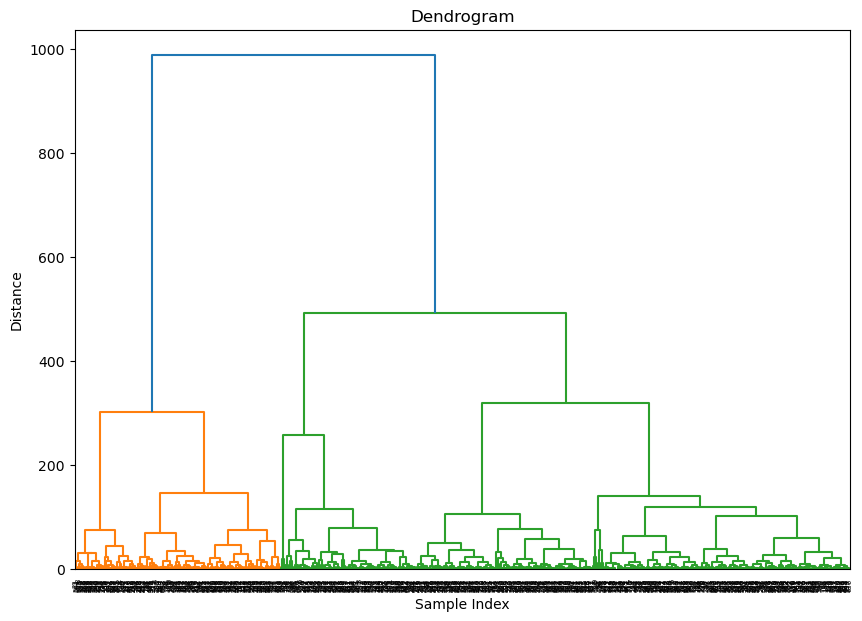

In [ ]:
# Generate linkage matrix
linkage_matrix = linkage(X, method='ward')

# Plot dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title('Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()


# Adjusted Rand Index (ARI)
To compare predicted clusters with ground truth labels:

In [ ]:
# Evaluate with Adjusted Rand Index (ARI)
ari_kmeans = adjusted_rand_score(y, y_kmeans)
ari_hierarchical = adjusted_rand_score(y, y_hierarchical)

print(f"K-Means Adjusted Rand Index: {ari_kmeans:.2f}")
print(f"Hierarchical Adjusted Rand Index: {ari_hierarchical:.2f}")


K-Means Adjusted Rand Index: 0.21
Hierarchical Adjusted Rand Index: 0.12


# Elbow Method (for K-Means)
To determine the optimal number of clusters:

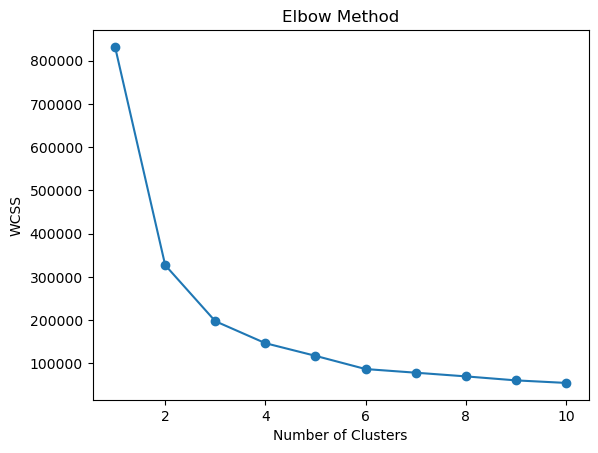

In [ ]:
# Elbow Method
wcss = []  # Within-cluster sum of squares
for k in range(1, 11):
    kmeans = KMeans(n_clusters = k, random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()


# Feature Selection - Filter Method

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
import pandas as pd

# Load dataset
diabetes_df = pd.read_csv('/Users/admin/Downloads/diabetes.csv')

y = diabetes_df['Outcome']
X = diabetes_df.drop('Outcome', axis = 1)

# Apply chi-squared test
chi2_selector = SelectKBest(chi2, k = 2)
X_kbest = chi2_selector.fit_transform(X, y)

#print(X_kbest)
print(chi2_selector.get_feature_names_out())

['Glucose' 'Insulin']


# Feature Selection - Wrapper Method

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Load dataset
diabetes_df = pd.read_csv('/Users/admin/Downloads/diabetes.csv')

y = diabetes_df['Outcome']
X = diabetes_df.drop('Outcome', axis = 1)

# Initialize model
model = LogisticRegression(max_iter=200)

# Apply RFE
rfe = RFE(model, n_features_to_select = 2)
X_rfe = rfe.fit_transform(X, y)


#print(X_rfe)
print(rfe.get_feature_names_out())

['Pregnancies' 'DiabetesPedigreeFunction']


# Dimensionality Reduction - Principal Component Analysis (PCA)

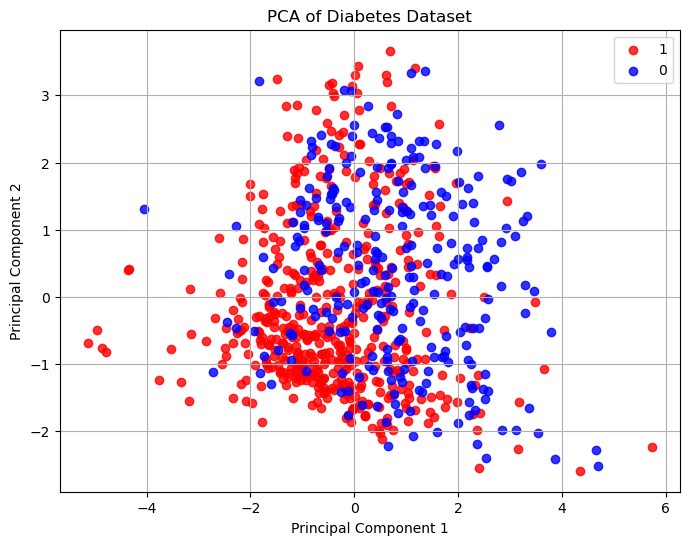

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

# Load the Iris dataset
#iris = load_iris()
#X = iris.data
#y = iris.target
# Load dataset
diabetes_df = pd.read_csv('/Users/admin/Downloads/diabetes.csv')

y = diabetes_df['Outcome']
X = diabetes_df.drop('Outcome', axis = 1)

target_names = y.astype("string").unique()

# Standardize the data (PCA works better with standardized data)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components = 2)  # Reduce to 2 components for visualization
X_pca = pca.fit_transform(X_scaled)

# Visualize the results
plt.figure(figsize=(8, 6))
colors = ['red', 'blue', 'green']

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], alpha=0.8, color=color, label=target_name)

plt.legend()
plt.title('PCA of Diabetes Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()

# t-SNE

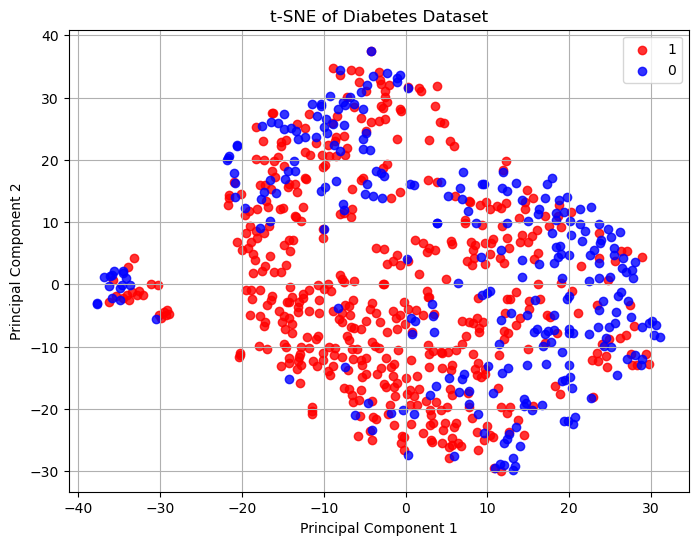

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

diabetes_df = pd.read_csv('/Users/admin/Downloads/diabetes.csv')

y = diabetes_df['Outcome']
X = diabetes_df.drop('Outcome', axis = 1)

target_names = y.astype("string").unique()

# Standardize the data (PCA works better with standardized data)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)


# Visualize the results
plt.figure(figsize=(8, 6))
colors = ['red', 'blue', 'green']

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_tsne[y == i, 0], X_tsne[y == i, 1], alpha=0.8, color=color, label=target_name)

plt.legend()
plt.title('t-SNE of Diabetes Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()

# Hyperparameter Tuning - Grid Search

In [ ]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris

# Load dataset
data = load_iris()
X, y = data.data, data.target

# Define the model and parameters
model = RandomForestClassifier()
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}


# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best Score: 0.9666666666666668
CPU times: user 30.2 s, sys: 570 ms, total: 30.7 s
Wall time: 31.3 s


# Hyperparameter Tuning - Randomised Search

In [ ]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from scipy.stats import randint

# Load dataset
data = load_iris()
X, y = data.data, data.target

# Define the model and parameters
model = RandomForestClassifier()
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 10)
}


# Perform random search
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy', random_state=42)
random_search.fit(X, y)

print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")


Best Parameters: {'max_depth': None, 'min_samples_split': 6, 'n_estimators': 152}
Best Score: 0.9666666666666668
CPU times: user 1min 33s, sys: 1.53 s, total: 1min 35s
Wall time: 1min 37s
